In [7]:
import numpy as np
import cv2
import heapq
import pickle
from google.colab.patches import cv2_imshow

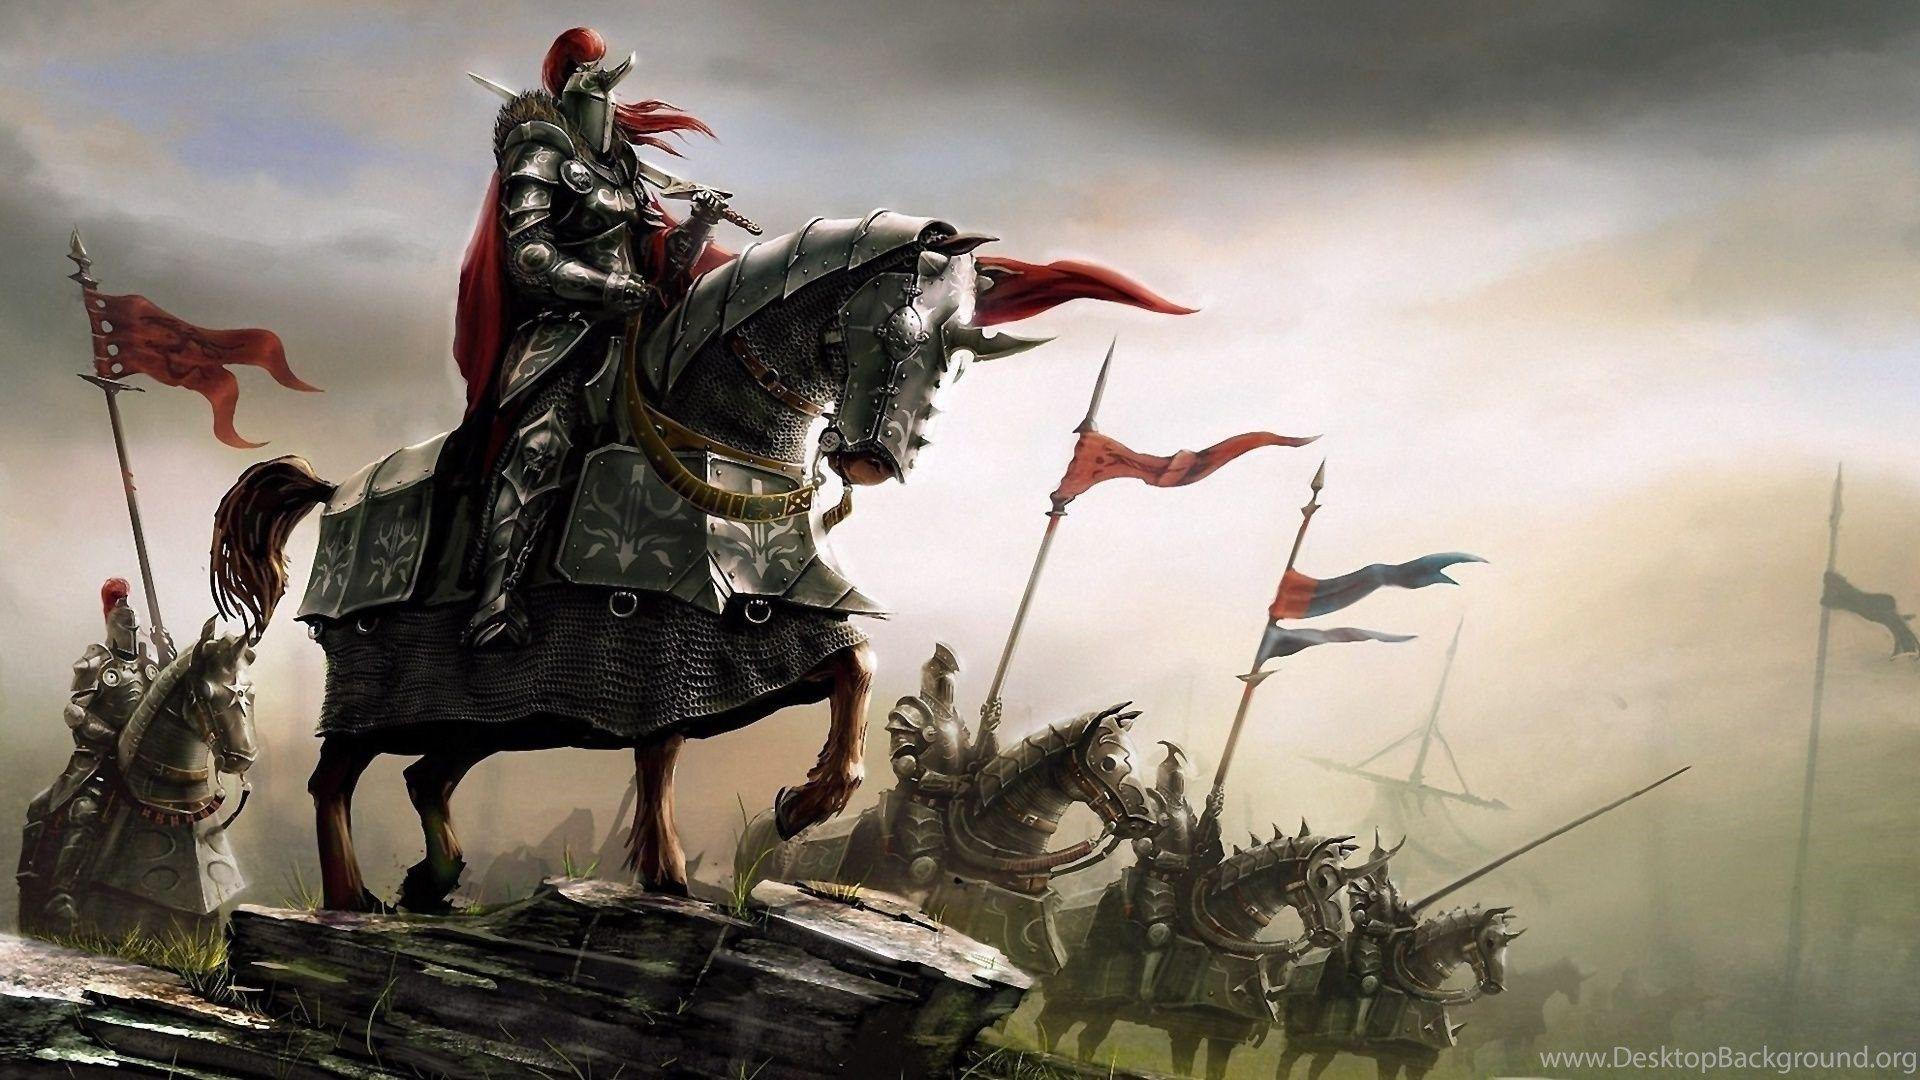

In [10]:
img = cv2.imread("771476.jpg")
# Display
cv2_imshow(img)

###Huffman Coding

In [11]:
class HuffNode:
    def __init__(self, symbol, freq):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None
    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(freqs):
    heap = [HuffNode(sym, f) for sym, f in freqs.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        a = heapq.heappop(heap)
        b = heapq.heappop(heap)
        parent = HuffNode(None, a.freq + b.freq)
        parent.left = a
        parent.right = b
        heapq.heappush(heap, parent)
    return heap[0]

def build_codes(node, code='', mapping=None):
    if mapping is None:
        mapping = {}
    if node.symbol is not None:
        mapping[node.symbol] = code or '0'
    else:
        build_codes(node.left, code + '0', mapping)
        build_codes(node.right, code + '1', mapping)
    return mapping

def huffman_compress(img, out_file="compressed_image.huff"):
    flat = img.flatten().tolist()
    freqs = {}
    for val in flat:
        freqs[val] = freqs.get(val, 0) + 1

    root = build_huffman_tree(freqs)
    codes = build_codes(root)

    bitstream = ''.join(codes[v] for v in flat)
    padding = 8 - len(bitstream) % 8
    bitstream += '0' * padding

    data = bytearray()
    for i in range(0, len(bitstream), 8):
        data.append(int(bitstream[i:i+8], 2))

    header = {
        'shape': img.shape,
        'codes': codes,
        'padding': padding
    }

    with open(out_file, 'wb') as f:
        pickle.dump((header, data), f)

    orig_size = img.size
    comp_size = len(data)
    ratio = orig_size / comp_size
    print(f"📦 Huffman compressed: {orig_size} bytes → {comp_size} bytes (ratio: {ratio:.2f}:1)")
    return out_file

def huffman_decompress(huff_file, out_image="reconstructed_from_huffman.png"):
    with open(huff_file, 'rb') as f:
        header, data = pickle.load(f)

    shape = header['shape']
    codes = header['codes']
    padding = header['padding']

    reverse_codes = {v: int(k) for k, v in codes.items()}
    bitstring = ''.join(format(byte, '08b') for byte in data)
    bitstring = bitstring[:-padding] if padding > 0 else bitstring

    current = ''
    decoded = []
    for bit in bitstring:
        current += bit
        if current in reverse_codes:
            decoded.append(reverse_codes[current])
            current = ''

    arr = np.array(decoded, dtype=np.uint8).reshape(shape)
    cv2.imwrite(out_image, arr)
    print(f"✅ Huffman decompressed and saved as: {out_image}")
    return arr


###Arithematic

In [12]:
def arithmetic_compress(img, out_file="compressed_image.arith"):
    """Arithmetic coding for grayscale using simplified approach"""
    flat = img.flatten().tolist()

    # Build frequency table
    freqs = {}
    for val in flat:
        freqs[val] = freqs.get(val, 0) + 1

    total = len(flat)
    symbols = sorted(freqs.keys())

    # Build cumulative frequency table (integer-based)
    cumul = {}
    cum = 0
    for s in symbols:
        cumul[s] = cum
        cum += freqs[s]

    # Encode using scaled integer arithmetic
    SCALE = 1 << 16  # 65536
    low = 0
    high = SCALE - 1

    # Collect output bits
    output_bits = []
    pending_bits = 0

    for pixel in flat:
        # Calculate new range
        range_size = high - low + 1
        high = low + (range_size * (cumul[pixel] + freqs[pixel])) // total - 1
        low = low + (range_size * cumul[pixel]) // total

        # Output bits
        while True:
            if high < SCALE // 2:
                # Output 0
                output_bits.append(0)
                output_bits.extend([1] * pending_bits)
                pending_bits = 0
                low = low * 2
                high = high * 2 + 1
            elif low >= SCALE // 2:
                # Output 1
                output_bits.append(1)
                output_bits.extend([0] * pending_bits)
                pending_bits = 0
                low = (low - SCALE // 2) * 2
                high = (high - SCALE // 2) * 2 + 1
            elif low >= SCALE // 4 and high < 3 * SCALE // 4:
                # Underflow - increment pending bits
                pending_bits += 1
                low = (low - SCALE // 4) * 2
                high = (high - SCALE // 4) * 2 + 1
            else:
                break

    # Output final bits
    pending_bits += 1
    if low < SCALE // 4:
        output_bits.append(0)
        output_bits.extend([1] * pending_bits)
    else:
        output_bits.append(1)
        output_bits.extend([0] * pending_bits)

    # Convert bits to bytes
    bitstring = ''.join(str(b) for b in output_bits)
    padding = (8 - len(bitstring) % 8) % 8
    bitstring += '0' * padding

    encoded_bytes = bytearray()
    for i in range(0, len(bitstring), 8):
        encoded_bytes.append(int(bitstring[i:i+8], 2))

    compressed_data = {
        'shape': img.shape,
        'freqs': freqs,
        'cumul': cumul,
        'total': total,
        'symbols': symbols,
        'encoded': bytes(encoded_bytes),
        'padding': padding
    }

    with open(out_file, 'wb') as f:
        pickle.dump(compressed_data, f)

    orig_size = img.size
    comp_size = len(encoded_bytes)
    ratio = orig_size / comp_size
    print(f" Arithmetic compressed: {orig_size} bytes → {comp_size} bytes (ratio: {ratio:.2f}:1)")
    return out_file

def arithmetic_decompress(arith_file, out_image="reconstructed_from_arithmetic.png"):
    """Decode arithmetic coding for grayscale"""
    with open(arith_file, 'rb') as f:
        compressed_data = pickle.load(f)

    shape = compressed_data['shape']
    freqs = compressed_data['freqs']
    cumul = compressed_data['cumul']
    total = compressed_data['total']
    symbols = compressed_data['symbols']
    encoded = compressed_data['encoded']
    padding = compressed_data['padding']

    # Convert bytes to bitstring
    bitstring = ''.join(format(byte, '08b') for byte in encoded)
    if padding > 0:
        bitstring = bitstring[:-padding]

    SCALE = 1 << 16
    low = 0
    high = SCALE - 1
    code = 0

    # Read initial bits into code
    for i in range(min(16, len(bitstring))):
        code = (code << 1) | int(bitstring[i])

    bit_pos = 16
    decoded = []
    pixels_needed = shape[0] * shape[1]

    for _ in range(pixels_needed):
        # Find symbol
        range_size = high - low + 1
        scaled_value = ((code - low + 1) * total - 1) // range_size

        # Binary search for symbol
        symbol = None
        for s in symbols:
            if cumul[s] <= scaled_value < cumul[s] + freqs[s]:
                symbol = s
                break

        if symbol is None:
            # Fallback to last symbol
            symbol = symbols[-1]

        decoded.append(symbol)

        # Update range
        high = low + (range_size * (cumul[symbol] + freqs[symbol])) // total - 1
        low = low + (range_size * cumul[symbol]) // total

        # Read more bits
        while True:
            if high < SCALE // 2:
                low = low * 2
                high = high * 2 + 1
                code = (code * 2) % SCALE
                if bit_pos < len(bitstring):
                    code |= int(bitstring[bit_pos])
                    bit_pos += 1
            elif low >= SCALE // 2:
                low = (low - SCALE // 2) * 2
                high = (high - SCALE // 2) * 2 + 1
                code = ((code - SCALE // 2) * 2) % SCALE
                if bit_pos < len(bitstring):
                    code |= int(bitstring[bit_pos])
                    bit_pos += 1
            elif low >= SCALE // 4 and high < 3 * SCALE // 4:
                low = (low - SCALE // 4) * 2
                high = (high - SCALE // 4) * 2 + 1
                code = ((code - SCALE // 4) * 2) % SCALE
                if bit_pos < len(bitstring):
                    code |= int(bitstring[bit_pos])
                    bit_pos += 1
            else:
                break

    arr = np.array(decoded, dtype=np.uint8).reshape(shape)
    cv2.imwrite(out_image, arr)
    print(f" Arithmetic decompressed and saved as: {out_image}")
    return arr


In [15]:
print("\n" + "="*50)
print("HUFFMAN CODING")
print("="*50)

# Convert to grayscale for Huffman to keep consistent
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

huff_file = huffman_compress(gray)
recon_huff = huffman_decompress(huff_file)

print("\n" + "="*50)
print("ARITHMETIC CODING")
print("="*50)

arith_file = arithmetic_compress(gray)
recon_arith = arithmetic_decompress(arith_file)

print("\n✅ Huffman and Arithmetic Compression Completed Successfully!")



HUFFMAN CODING
📦 Huffman compressed: 2073600 bytes → 2053621 bytes (ratio: 1.01:1)
✅ Huffman decompressed and saved as: reconstructed_from_huffman.png

ARITHMETIC CODING
 Arithmetic compressed: 2073600 bytes → 2048431 bytes (ratio: 1.01:1)
 Arithmetic decompressed and saved as: reconstructed_from_arithmetic.png

✅ Huffman and Arithmetic Compression Completed Successfully!


In [16]:
print("\n" + "="*50)
print("DOWNLOADING FILES")
print("="*50)
files.download("compressed_image.huff")
files.download("reconstructed_from_huffman.png")
files.download("compressed_image.arith")
files.download("reconstructed_from_arithmetic.png")

print("\n🎯 Done! All compressed and reconstructed images are ready for download.")
print(f"\nOriginal shape: {img.shape}")
print(f"Huffman reconstruction matches: {np.array_equal(img, recon_huff)}")
print(f"Arithmetic reconstruction matches: {np.array_equal(img, recon_arith)}")



DOWNLOADING FILES


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🎯 Done! All compressed and reconstructed images are ready for download.

Original shape: (1080, 1920, 3)
Huffman reconstruction matches: False
Arithmetic reconstruction matches: False
